## How to calculate Longitudinal Strain from Our Motion Tracking Information

In [59]:
def strain_value(l_0, l_i):
    '''
    inputs: l_0, l_i -- original length and new length at some time point, respectively
    output: e -- strain value (positive for elongation, negative for compressing/shortening)
    
    examples: 
        l_i = 10
        l_0 = 5
        e == (10 - 5) / 5 = 1, factor of lengthening relative to original value
        
        l_i = 5
        l_0 = 5
        e == (5 - 5) / 5 = 0, no strain
    '''
    return (l_i - l_0) / l_0

### Let's import our models and the test dataset, then do inference on one video, then grab motion tracking information

1. Import Models
2. Import Test Dataset
3. Inference on 1 test video
4. Choose a specific region of interest to calculate strain of, for now let's try to focus on the apical region of the left ventricle
5. Use motion tracking information to warp from the ED frame to the ES frame. 
6. Calculate the strain on a specific pixel on the apical region of the LV using `l_0` to be a pixel from the ED frame and the `l_i` to be a pixel from the ES frame

In [2]:
import os
os.chdir("../..")

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset


from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet 

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet



# from src.visualization_utils import categorical_dice
%matplotlib widget
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [4]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.62it/s]


In [5]:
len(test_dataset)

1276

In [6]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

In [7]:
# model_names = ["Original-Pretrained-R2plus1DMotionSegNet_model.pth", "dropout-0_10-R2plus1DMotionSegNet_model.pth", "dropout-0_25-R2plus1DMotionSegNet_model.pth", "dropout-0_50-R2plus1DMotionSegNet_model.pth", "dropout-0_75-R2plus1DMotionSegNet_model.pth"]

model_names = ['Original-Pretrained-R2plus1DMotionSegNet_model.pth']

In [8]:
loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
    
    # original model
    if model_name == "Original-Pretrained-R2plus1DMotionSegNet_model.pth":
        # model = DDP(R2plus1D_18_MotionNet())
         model = torch.nn.DataParallel(R2plus1D_18_MotionNet(), device_ids = [1, 0])
        
    # altered models
    if model_name == "dropout-0_75-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_75_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_75_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_50-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_50_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_50_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_25-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_25_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_25_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_10-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_10_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_10_R2plus1D_18_MotionNet())
    
    # dropout v2 models
    if model_name == 'dropout_v2-0_10-R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_10_R2plus1D_18_MotionNet())
    
    #### TEMPORARY: use GPU 2 (cuda:1) because we were training another model simultaneously at the moment of writing.
    
    
    model.to(f'cuda:{model.device_ids[0]}')
    # model.to("cuda:1")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))

Original-Pretrained-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
1


In [9]:
# test_pat_index = np.random.randint(len(test_dataset))
test_pat_index = 0  # first video from test dataset


video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

video.shape

# shape is RGB, total num frames, Width, Height

(3, 248, 112, 112)

In [10]:
# find the ED and ES index
print(f'ed_index: {ed_index}, es_index: {es_index}')

ed_index: 132, es_index: 148


In [11]:
ed_clip_index, es_clip_index

(132, 148)

In [12]:
ed_frame.shape, es_frame.shape

((3, 112, 112), (3, 112, 112))

### Get all possible 32-Frame Clips that covers ED-ES

In [13]:
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
print(f'len: {len(possible_starts)}, {possible_starts}')
print(possible_starts[-1])

len: 16, [117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132]
132


In [14]:
# prove to ourselves that in the first clip as listed above, our es index is the last frame (32nd frame) in our [0, 31] frames
print(f'{possible_starts[0] + 31} == {es_index}')

148 == 148


## Grab a clip from the raw video data where the ED frame is the first frame.

In [15]:
video.shape

(3, 248, 112, 112)

In [16]:
# last clip in all possible starts will be where ED is first frame, ES some number of frames later
video_clip = video[:, possible_starts[-1] : possible_starts[-1] + 32, :, :]
video_clip.shape

(3, 32, 112, 112)

### Segment the 32-Frame video clips that do cover ED-ES (NOT CONSECUTIVE)
If the video length is not a multiple of 32 (32-frame video clips), then interpolate the video so its length equals to the nearest multiple of 32.

For example, a video with length 88 will be interpolated to 96, and a video with length 72 will be interpolated to 64.

In [17]:
# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)

In [18]:
all_motion_outputs[0].shape
# should have number of possible clips, 4 directions, 32 frames, W, H

(16, 4, 32, 112, 112)

### Now that we have the motion outputs, let us start from the ED frame, warp continously until we hit the ES frame

1. What does a single warp look like? well, let us go into the loss functions to see where Yida is applying a warp and comparing a warped frame with the actual frame to compute a loss.
2. Knowing how to apply the warp, let us also visualize that.
3. Then, let us define functions to warp from ED to ES continuously (and make sure it's doing what you think it's doing, continuously warping the previous frame till ES frame index)
4. First, define a single pixel in the ED frame to be `l_0`. Now, calculate how far a single pixel has travel from the ED to the ES frame, call that `l_i`. Calculate strain...
5. Then, compare with ? I'm still not sure how to calculate a "ground truth strain" to compare against and calculate a loss for. 

In [19]:
# from transform_utils.py
def generate_2dmotion_field(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    x_shape = x.size()
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)

    offset_h, offset_w = torch.split(offset, 1, 1)
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    offsets = torch.stack((offset_h, offset_w), 3)

    return offsets


# from the clasfv_losses.py 
def deformation_motion_loss(source_videos, motion_field):
    """
        OTA loss for motion tracking on echocardiographic frames
    """
    mse_criterion = nn.MSELoss()
    mse_loss = 0
    smooth_loss = 0
    
    # Deform both forward and backward from beginning to the end of video clip 
    for index in range(source_videos.shape[2] - 1):
        forward_motion = motion_field[:, :2, index,...]
        backward_motion = motion_field[:, 2:, index + 1,...]
        
        grid_forward = generate_2dmotion_field(source_videos[:, :, index,...], forward_motion)
        grid_backward = generate_2dmotion_field(source_videos[:, :, index + 1,...], backward_motion)
        
        pred_image_forward = F.grid_sample(source_videos[:, :, index,...], grid_forward, 
                                           align_corners=False, padding_mode='border')
        pred_image_backward = F.grid_sample(source_videos[:, :, index + 1,...], grid_backward, 
                                            align_corners=False, padding_mode='border')
        
        mse_loss += mse_criterion(source_videos[:, :, index + 1,...], pred_image_forward)
        mse_loss += mse_criterion(source_videos[:, :, index,...], pred_image_backward)
        
        smooth_loss += huber_loss(forward_motion)
        smooth_loss += huber_loss(backward_motion)
    
    # Averaging the resulting loss
    return (0.005 * smooth_loss + mse_loss) / 2 / (source_videos.shape[2] - 1)

#### Looking at this, we could also create forward and backward to have 2 values of longitudinal strain and see if they match, and ideally they should be as close to each other as possible.

1. Transform ED -> ES, compute strain A.
2. Transform ED <- ES, compute strain B.
3. Compare A with B. They should be as close to one another's value as possible in terms of magnitude.
4. Compare A and B with a ground truth value (TODO: how to calculate a 'ground truth' strain value)


1. Grab a portion of the motion tracking output info for some clip of 32 frames that should have a ED -> ES frame.
2. Need to grab the ED and ES frame index within this 32 frames clip.

In [20]:
all_motion_outputs[0][-1].shape # grab the last 32 frame clip, frame 0 of this clip will be ED frame

(4, 32, 112, 112)

In [21]:
# how many frames ahead is the ES frame relative to the ED frame?
delta_ed_es_frames = es_index - ed_index
delta_ed_es_frames

16

### Now we know that in the [0, 31] frames, ED @ i = 0, ES @ i = 16

In [22]:
original_32_frame_clip_motion_outputs = all_motion_outputs[0][-1]
original_32_frame_clip_motion_outputs.shape

(4, 32, 112, 112)

In [23]:
video_clip.shape

(3, 32, 112, 112)

In [24]:
def warp_one_forward(frame, motion_field, index):
    '''
    warp forward from frame_i -> frame_iplus1
    return new frame
    
    frame: (3, 32, 112, 112)
    motion_field: (4, 32, 112, 112)
    '''
    # convert numpy ndarrays to tensor objects
    frame = torch.from_numpy(frame)
    motion_field = torch.from_numpy(motion_field)
    
    
    # create the forward grid from forward motion and adjust shapes
    forward_motion = motion_field[:2, index, ...]
    frame = frame[:, index, ...]
    
    # create forward prediction frame
    forward_pred_frame = F.grid_sample(frame, forward_motion,
                                       align_corners=False, padding_mode='border')
    
    return forward_pred_frame
    

def warp_one_backward(frame, motion_field, index):
    '''
    warp backward from frame_i -> fram_iminus1
    return new frame
    
    frame: (3, 32, 112, 112)
    motion_field: (4, 32, 112, 112)
    '''
    # create the backward grid from backward motion
    backward_motion = motion_field[:2, ...]
    
    # create forward prediction frame
    backward_pred_frame = F.grid_sample(frame[:, index, ...], backward_motion,
                                       align_corners=False, padding_mode='border')
    
    return backward_pred_frame

In [25]:
# for_warp_holder = video_clip
# for_warp_holder = for_warp_holder.astype("double")
# motion_field = original_32_frame_clip_motion_outputs.astype("double")

# print(for_warp_holder.dtype, motion_field.dtype)

# for i in range(32):
#     for_warp_holder = warp_one_forward(for_warp_holder, motion_field, i)

Train cycle uses batches from the trainloader. The size of the `video_clips` that is passed into the function of interest `deformation_motion_loss` has shape of `4, 3, 32, 112, 112`. <br>
An original video clip loaded in from the test dataset for example (`test_pat_index = 0`) has shape of `(3, 248, 112, 112)` <br>
Then the segment `source_videos.shape[2] - 1` from `deformation_motion_loss` function would be: `32 - 1 = 31`. Therefore, the for loop `for index in range(source_videos.shape[2] - 1):` would loop from `[0, 30]` indeces for the frames. <br>
Note that we skip the last frame. I'm not sure why as of now. I suppose there is no forward frame from the last frame to compare to. However, if that is the case why did we not skip `0` and start with `1` if we are also performing backwards warping, as there is no frame before the `0`th frame to compare to as well.

In [26]:
# with open("fold_indexes/stanford_train_sampled_indices", "rb") as infile:
#     train_mask = pickle.load(infile)
# infile.close()
# train_dataset = EchoNetDynamicDataset(split='train', subset_indices=train_mask, period=1)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
#                               num_workers=num_workers, 
#                               shuffle=True, pin_memory=("cuda"), 
#                               worker_init_fn=worker_init_fn,
#                               drop_last=True)


In [27]:
# Tensor = torch.cuda.FloatTensor
# for batch_idx, batch in enumerate(train_dataloader, 1):
#     video_clips = torch.Tensor(batch[0])
#     video_clips = video_clips.type(Tensor)
    
#     print(video_clips.shape)
#     filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label = batch[1]
#     break

## Can we draw a polygon of the outline of the LV from the segmentation output from the model?

In [28]:
all_segmentation_outputs[0].shape

(16, 2, 32, 112, 112)

In [29]:
clip_with_ed_frame_index_0 = all_segmentation_outputs[0][-1] # grab the last clip where ED frame is the first frame\

clip_with_ed_frame_index_0.shape

(2, 32, 112, 112)

In [30]:
# for the dimension of 2 for seg out, 0 is background, 1 for lv

ed_frame_background_seg = clip_with_ed_frame_index_0[0][0]
es_frame_background_seg = clip_with_ed_frame_index_0[0][delta_ed_es_frames]


ed_frame_lv_seg = clip_with_ed_frame_index_0[1][0] # 1 for lv, 0 for ed frame index
es_frame_lv_seg = clip_with_ed_frame_index_0[1][delta_ed_es_frames] # 1 for lv, delta_ed_es_frames for es frame index


ed_frame_lv_seg.shape, es_frame_lv_seg.shape, ed_frame_background_seg.shape, es_frame_background_seg.shape

((112, 112), (112, 112), (112, 112), (112, 112))

In [53]:
# try to look at the two layers
# plt.imshow(x[0][0], vmin=0, vmax=1)   # first one is the background mask
plt.title('ed frame lv seg')
plt.imshow(ed_frame_lv_seg, cmap="gray")
plt.colorbar()
# fig.colorbar(ax4_img, ax=ax4)

In [32]:
plt.title('es frame lv seg')
plt.imshow(es_frame_lv_seg)  # this one is the labeling of the left ventricle segmentation
plt.colorbar()

In [33]:
# convert these into binary masks.
# want larger value translated into 1, smaller value translated into 0
print('should be opposites:', ed_frame_lv_seg[0][0], ed_frame_background_seg[0][0])
print('should be opposites:', es_frame_lv_seg[0][0], es_frame_background_seg[0][0])

should be opposites: -8.109314918518066 8.144218444824219
should be opposites: -8.063018798828125 8.074203491210938


In [34]:
foo = np.argmax(clip_with_ed_frame_index_0, axis=0)
foo.shape

(32, 112, 112)

In [35]:
plt.title('binary mask of ed lv seg ??')
plt.imshow(foo[0])
plt.colorbar()

In [36]:
plt.title('binary mask of es lv seg ??')
plt.imshow(foo[delta_ed_es_frames])
plt.colorbar()

## In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black.

so we need to multiply our values by 255

In [37]:
foo_times_255 = 255 * foo

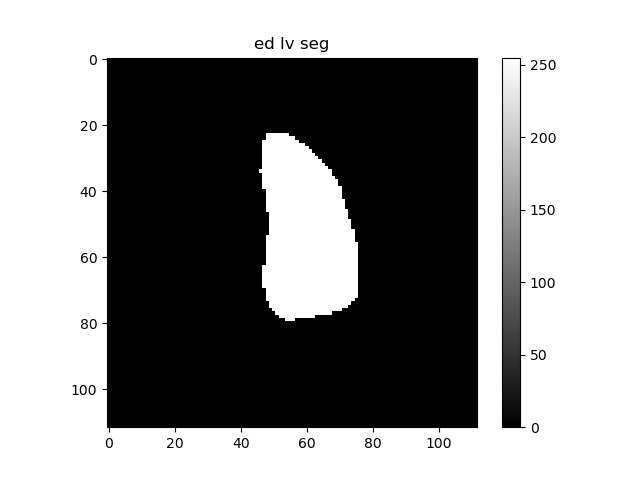

In [55]:
plt.figure()
plt.title('ed lv seg')
plt.imshow(foo_times_255[0], cmap='gray')
plt.colorbar()

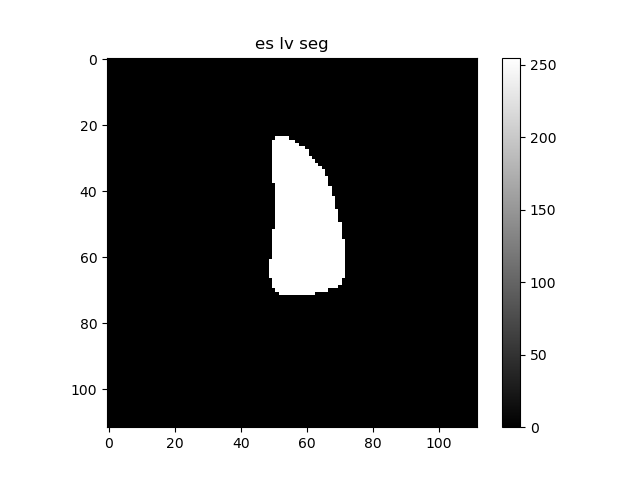

In [57]:
plt.figure()
plt.title('es lv seg')
plt.imshow(foo_times_255[delta_ed_es_frames], cmap='gray')
plt.colorbar()

In [40]:
# use this to get contour ? https://stackoverflow.com/questions/58885816/how-to-obtain-boundary-coordinates-of-binary-mask-with-holes

image_8bit = np.uint8(foo * 255)   # convert to black and white and use 8-bit int data type

ed_im = image_8bit[0]
es_im = image_8bit[delta_ed_es_frames]

import cv2 as cv

ret, thresh = cv.threshold(ed_im, 127, 255, 0)
ed_contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

ret, thresh = cv.threshold(es_im, 127, 255, 0)
es_contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [42]:
type(ed_contours), type(es_contours)

(tuple, tuple)

In [44]:
len(ed_contours), len(es_contours)

(1, 1)

In [46]:
ed_contours[0].shape

(52, 1, 2)

In [47]:
ed_contours[0][0]

array([[48, 23]], dtype=int32)

In [48]:
hierarchy.shape

(1, 1, 4)

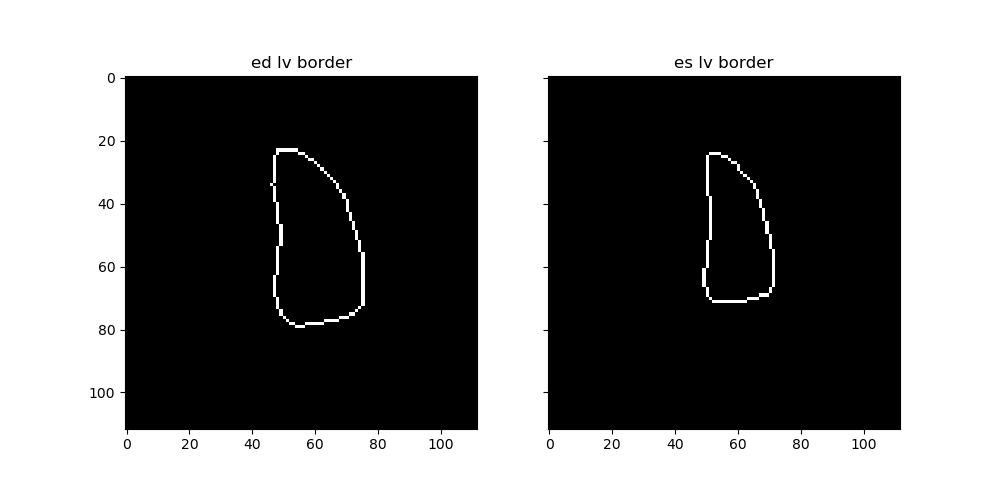

In [58]:
borders_list = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
blank = np.zeros((112,112))

ax1.imshow(cv.drawContours(blank, ed_contours, -1, (255,255,255), 1), cmap='gray')
ax1.set_title("ed lv border")
borders_list.append(blank)

blank = np.zeros((112,112))
ax2.imshow(cv.drawContours(blank, es_contours, -1, (255,255,255), 1), cmap='gray')
ax2.set_title("es lv border")
borders_list.append(blank)

In [50]:
len(borders_list)

2

In [51]:
np.count_nonzero(borders_list[0] == 255)

135

In [52]:
np.count_nonzero(borders_list[1] == 255)

114

### So the number of pixels representing the border in the ED frame is not the same in the ES frame. I suppose this makes sense because the ED frame has a bigger border as compared to the ES frame being the smallest the lv border is possibly ever.

### Now, at least we have an idea of how to get the border pixels at the ED and ES frames from the model segmentation outputs.

### Start from ED Boundary mask and transform it forward the number of frames between the ED and ES frames using the motion tracking information. Then, 


### Wait, why not just compute longitudinal strain from the segmentation outputs? We don't even need the motion tracking. I suppose, we could do both:
#### 1. Compute strain using our segmentation outputs
#### 2. Compute strain using both segmentation and motion outputs
#### 3. Compute strain using the boundary taken from the mask of the ED LV from the raw dataset and transform it using the motion tracking information.

#### 0. Let's try to look at the perimeter as lengths (in this case we are just using the count of the pixels of the border)

In [62]:
l_0 = np.count_nonzero(borders_list[0] == 255)
l_i = np.count_nonzero(borders_list[1] == 255)
strain_value(l_0, l_i)

-0.15555555555555556

### You know, ~ -15% strain means that we contracted by about 15% length....this is a reasonable number but this calculation feels wrong. However, I need some ground truth value to compare against, and I haven't done that yet.